In [10]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5, tavily_api_key="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")

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:24: SyntaxWarning: invalid escape sequence '\`'
<>:24: SyntaxWarning: invalid escape sequence '\`'
<>:24: SyntaxWarning: invalid escape sequence '\`'
<>:24: SyntaxWarning: invalid escape sequence '\`'
/var/folders/yz/s57wsyt918j04kt6btpgwgy40000gn/T/ipykernel_46390/1802447857.py:24: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/var/folders/yz/s57wsyt918j04kt6btpgwgy40000gn/T/ipykernel_46390/1802447857.py:24: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [4]:
# creating individual agents
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [14]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

# llm = ChatAnthropic(model = "claude-3-5-sonnet-latest")
llm = ChatOpenAI(model = "gpt-4o")

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # any agent decided the work is done
        return END
    return goto

# research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list 
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

# chart generator agent and node
# note: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    )
)

def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [7]:
# define the graph
# we can now put in all together and define the graph
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

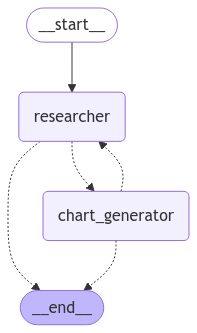

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # this requires some extra dependencies and is optional
    pass

In [15]:
# invoke
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("-----")

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='afc45926-0d31-4720-a2e7-3fc709394d6a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yZbHHsaE9ySSLAfHexHFnT0e', 'function': {'arguments': '{"query":"UK GDP past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 210, 'total_tokens': 234, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-653c24c5-357f-49b8-b02f-0eaeca1a5016-0', tool_calls=[{'name': 'tavily_se